<a href="https://colab.research.google.com/github/KSY1526/myblog/blob/master/_notebooks/2022-02-24-torch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "[DACON] 사물 이미지 분류 경진대회 With Pytorch"
- author: Seong Yeon Kim 
- categories: [jupyter, Deep Learning, Pytorch, DACON, Classifier, conputer vision] 
- image: images/220204.png

# 데이터 구글 드라이브에 저장하기

In [162]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


코랩과 구글 드라이브를 연동하는 코드입니다. 구글 드라이브 내 파일을 코랩에서도 접근할 수 있게됩니다.

In [163]:
# %cd /content/drive/MyDrive/ObjectDetect

# !unzip -qq '/content/drive/MyDrive/ObjectDetect/data.zip'

데이터를 저장하는 다른 더 좋고 빠른 방법이 있을 수도 있는데, 제가 발견한 방법 중 가장 좋은 방법을 소개합니다.

우선 데이콘 내 데이터를 압축된 형태로 다운받고, 구글 드라이브 내 압축된 파일 그대로 업로드 합니다.

(제 기준 /content/drive/MyDrive/ObjectDetect 공간에 data.zip 파일을 넣었습니다. 여러분 상황에 맞게 주소를 바꾸시면 됩니다.)

그 후 위 코드를 주석을 해제한 뒤 주소를 data.zip을 저장한 위치로 수정하시고 코드를 실행하시면 약 5분 뒤 압축 해제가 잘 됩니다.

압축 해제 후 구글 드라이브 업로드, 구글 드라이브 내 압축 해제보다는 이 방법이 괜찮은 것 같아 소개합니다.

더 좋은 방법 있으면 같이 공유 부탁드려요~

# 필요한 패키지 설치하고 기본 설정 하기

In [164]:
import os
from glob import glob
from typing import Tuple, Sequence, Callable

import numpy as np
import pandas as pd

import PIL
from PIL import Image
from matplotlib.pyplot import imshow

import torch
import torch.optim as optim
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

!pip install torchinfo
from torchinfo import summary

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from tqdm import tqdm, tqdm_notebook

파이토치, 넘파이, 판다스 등 필요한 패키지를 임포트 했습니다.

In [186]:
path = '/content/drive/MyDrive/ObjectDetect/'

batch_size = 32
num_epochs = 20
learning_rate = 0.001

labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# gpu 사용중일땐 cuda, gpu 사용 불가능할땐 cpu 사용.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

데이터의 저장 위치와 배치 사이즈, 에포크 수, 러닝 레이트 값, 장치 등을 지정했습니다. 

각 레이블 번호는 알파벳 순서대로 배정했습니다.

이 코드를 따라하신다면 path만 파일 저장 위치로 바꾸시면 됩니다.

# 데이터 불러오기

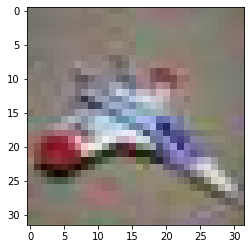

In [166]:
img = Image.open(path + 'train/airplane/0001.jpg') 
imshow(np.asarray(img))

PIL와 matplotlib 패키지를 가지고 이미지를 시각화 할 수 있습니다. 

데이터 분석을 하기 전 그래도 이미지 데이터인데 한번 시각적으로 확인했습니다.

In [167]:
train_images = []
train_labels = []

i = 0
for filename in sorted(glob(path + "train/*")):
    for img in tqdm(glob(filename + "/*.jpg")):
        an_img = PIL.Image.open(img) # 이미지를 읽습니다.
        img_array = np.array(an_img) # 이미지 데이터를 숫자로 변환합니다.
        train_images.append(img_array) # 리스트에 데이터 실기.
        label = i 
        train_labels.append(label)

    i += 1 # 다음 폴더에는 다음 라벨

train_images = np.array(train_images)

print(train_images.shape)

100%|██████████| 5000/5000 [00:12<00:00, 404.29it/s]


(50000, 32, 32, 3)


파이토치 내 ImageFolder 함수를 사용하는 것이 편리하지만, 이후 모델 학습시 데이터를 찾을때 계속 구글드라이브를 탐색하는 형태이기 때문에 지나치게 느립니다.

그래서 트레인 데이터를 폴더 별로 반복문을 사용해 모두 직접 다운로드 하였습니다.

sorted로 폴더 이름을 정렬한 뒤 i를 업데이트 했기 때문에 알파벳 순서대로 라벨 숫자를 입력했습니다.

입력된 데이터를 관찰하면 개수가 5만개이며 32 * 32 이미지 픽셀이고, 3채널(RGB값) 으로 구성되있습니다!

In [239]:
test_images = []


for filename in tqdm(sorted(glob(path + "test/*.jpg"))):
    an_img = PIL.Image.open(filename) # 이미지를 읽습니다.
    img_array = np.array(an_img) # 이미지 데이터를 숫자로 변환합니다.
    test_images.append(img_array) # 리스트에 데이터 실기.

test_images = np.array(test_images)

100%|██████████| 10000/10000 [00:25<00:00, 385.08it/s]


테스트 데이터도 마찬가지로 진행했습니다.

# 불러온 데이터로 데이터 셋 만들기

In [169]:
class CustomDataset(Dataset):
    def __init__(self, transform, mode = 'train'):
        self.transform = transform 
        if mode == 'train':
            self.img_list = train_images 
            self.img_labels = train_labels
        elif mode == 'test':
            self.img_list = test_images
            self.img_labels = [0] * 10000 # 형식을 맞추기 위해

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(self.img_list[idx]), self.img_labels[idx]

파이토치 내 Dataset 클래스를 상속해서 Dataset을 정의했습니다. 뒤에 다루는 DataLoader 클래스와 호환이 되기 때문에 반드시 필요합니다.

추상 클래스이기 때문에 반드시 새로 정의해야 하는 함수는 init, len, getitem 입니다.

init 부분은 클래스 선언시 자동으로 실행되는 함수입니다. 생성자 개념이죠. 이미지 데이터와 라벨값을 저장해줍니다.

이때 테스트 데이터는 라벨이 없지만, 형식을 맞춰주기 위해 임의로 0라벨을 붙히겠습니다.

len 부분은 데이터 길이만 배출하면 됩니다. getitem 부분은 정해진 인덱스의 데이터를 출력해줘야 합니다.

DataLoader가 len과 getitem 함수를 사용하기 때문에 잘 정의해야합니다.

In [242]:
tensor = transforms.Compose(
    [transforms.ToTensor()]
)

train_set = CustomDataset(tensor, mode = 'train')
test_set = CustomDataset(tensor, mode = 'test')

파이토치 모델은 텐서 단위로 다루기 때문에 텐서로 변환하는 transforms 을 만든 뒤 데이터 셋을 만듭니다.

In [243]:
meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_set]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_set]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.49125046 0.48208782 0.44651186
0.20106333 0.19889629 0.20135581


입력된 이미지 데이터를 정규화(표준화) 시켜주겠습니다. 정규화를 위해서 표본 평균과 표준오차를 구하는 모습입니다.

In [244]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

train_set.transform = transform
test_set.transform = transform

파이토치 내 Compose 함수를 한번 더 사용하고, 앞서 구한 표본평균과 표준오차를 이용해 transform을 만들었습니다.

데이터를 데이터 셋 형태로 정리했기 때문에 'train_set.transform = transform' 이 코드만 사용하면 간편하게 적용이 가능합니다.

In [176]:
train_set.__len__()

50000

In [179]:
train_set.__getitem__(40)

(tensor([[[-0.5124, -0.5124, -0.4538,  ..., -0.4343, -0.4538, -0.4538],
          [-0.5124, -0.5124, -0.4538,  ..., -0.4538, -0.4538, -0.4733],
          [-0.5514, -0.5709, -0.5124,  ..., -0.4733, -0.4733, -0.4928],
          ...,
          [-1.6826, -1.6436, -1.6241,  ..., -1.7801, -1.7216, -1.5656],
          [-1.6631, -1.6436, -1.6241,  ..., -1.3510, -1.3705, -1.5071],
          [-1.7606, -1.7411, -1.7216,  ..., -1.7216, -1.7021, -1.5656]],
 
         [[ 0.2379,  0.2379,  0.2971,  ...,  0.3957,  0.3759,  0.3759],
          [ 0.2379,  0.2379,  0.2971,  ...,  0.3759,  0.3759,  0.3562],
          [ 0.2576,  0.2379,  0.2971,  ...,  0.3562,  0.3562,  0.3365],
          ...,
          [-1.1028, -1.1028, -1.0831,  ..., -1.3591, -1.3591, -1.2014],
          [-1.0831, -1.0634, -1.0831,  ..., -0.9845, -1.0042, -1.1422],
          [-1.1817, -1.1619, -1.1422,  ..., -1.3591, -1.3394, -1.2014]],
 
         [[ 0.4117,  0.4117,  0.4701,  ...,  0.3922,  0.3728,  0.3728],
          [ 0.4117,  0.4117,

실제 값으로 확인해보면 32 * 32가 맞는것으로 보이며, 뒤에 라벨 값으로 0이 달려있는 모습입니다.

__len __, __getitem __함수로 데이터 값을 불러올 수 있는 걸 보니 파이토치 내 Dataset 클래스 형태로 데이터가 잘 입력된 것 같습니다.

# 데이터셋을 데이터 로더에 실기

In [245]:
train_loader = DataLoader(train_set, batch_size = batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers=2)

앞서 정의한 데이터 셋을 파이토치 내 데이터 로더에 실습니다. 이렇게 하는 이유는 배치단위로 모델에 적용하기 쉽기 때문입니다.

여기서 중요한 점은 테스트 데이터는 셔플을 해줘야 합니다. 데이터가 라벨 값으로 정렬되어 있는데, 학습에 큰 문제가 되기 때문입니다.

셔플을 True로 해주게 되면 또 하나의 장점이 에포크가 바뀔때마다 로더 내 데이터 패치를 다시 섞어줍니다.

In [181]:
for batch_idx, samples in enumerate(train_loader):
    if batch_idx > 0:
        break
    print(samples[0].shape)
    print(samples[1])

torch.Size([32, 3, 32, 32])
tensor([2, 8, 2, 5, 7, 1, 9, 0, 8, 0, 3, 1, 7, 2, 9, 6, 3, 6, 2, 9, 2, 1, 5, 5,
        9, 8, 2, 8, 1, 6, 5, 1])


데이터 로더를 보다 상세히 관찰해보면 배치단위, 채널수, 32 * 32 로 잘 들어가 있는걸 관찰할 수 있으며, 라벨값도 잘 들어가 있습니다.

# 모델 만들기

In [182]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet50(pretrained=False)
        self.classifier = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)

        return x

파이토치 내 nn.Module 클래스를 상속하고 resnet50 을 사용하여 모델을 정의했습니다.

이때 대회 규칙 상 사전학습이 안되므로 pretrained=False 로 잘 지정해줘야합니다.

In [188]:
model = Model().to(device)
print(summary(model, input_size = (1,3,32,32)))

Layer (type:depth-idx)                        Output Shape              Param #
Model                                         --                        --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 16, 16]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 16, 16]           128
│    └─ReLU: 2-3                              [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-4                         [1, 64, 8, 8]             --
│    └─Sequential: 2-5                        [1, 256, 8, 8]            --
│    │    └─Bottleneck: 3-1                   [1, 256, 8, 8]            75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 8, 8]            70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 8, 8]            70,400
│    └─Sequential: 2-6                        [1, 512, 4, 4]            --
│    │    └─Bottleneck: 3-4                   [1, 512, 4, 4]            379,392

파이토치에서 중요하게 알아두어야 할 것이 디바이스(GPU를 주로 사용합니다) 내 실어줘야 하는것이 모델과 입력 값, 라벨 값 입니다.

여기서 to(device) 를 사용하여 모델을 디바이스 내 실어주었습니다.

앞서 정의한 모델을 직관적으로 관찰하기 위해 torchinfo(summary) 를 사용하였습니다.

모델 구조가 복잡한 것도 그렇고, 모델 파라미터는 25,567,042개니 역시 '딥'러닝이네요. 



# 모델 학습하기

In [189]:
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

model.train()

for epoch in range(num_epochs):
    for i, (images, targets) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            max_vals, max_indices = torch.max(outputs, 1)
            acc = (targets == max_indices).float().mean()
            print(f'{loss.item():.5f}, {acc.item():.5f}')

201it [00:20,  9.48it/s]

2.03402, 0.25000


402it [00:41,  9.71it/s]

1.68516, 0.40625


601it [01:01,  9.59it/s]

2.04422, 0.28125


802it [01:21,  9.71it/s]

1.48867, 0.46875


1001it [01:41,  9.63it/s]

1.43756, 0.46875


1202it [02:02,  9.70it/s]

1.60528, 0.40625


1402it [02:22,  9.63it/s]

1.23092, 0.62500


1563it [02:39,  9.82it/s]
201it [00:20,  9.62it/s]

1.57936, 0.43750


401it [00:40,  9.75it/s]

1.51674, 0.43750


602it [01:01,  9.75it/s]

1.81981, 0.37500


801it [01:21,  9.59it/s]

1.41190, 0.56250


1000it [01:42,  9.32it/s]

1.63900, 0.40625


1201it [02:04,  9.56it/s]

1.07908, 0.59375


1401it [02:26,  9.69it/s]

1.33048, 0.56250


1563it [02:42,  9.62it/s]
201it [00:21,  9.40it/s]

1.38050, 0.53125


401it [00:41,  9.25it/s]

1.46519, 0.50000


601it [01:02,  9.59it/s]

1.54906, 0.43750


801it [01:22,  9.61it/s]

1.55637, 0.40625


1001it [01:43,  9.65it/s]

1.28245, 0.59375


1202it [02:03,  9.77it/s]

1.17159, 0.59375


1401it [02:24,  9.53it/s]

1.21823, 0.59375


1563it [02:40,  9.72it/s]
201it [00:20,  9.41it/s]

1.38219, 0.53125


401it [00:41,  9.45it/s]

1.07596, 0.68750


601it [01:02,  9.57it/s]

1.51185, 0.50000


801it [01:22,  9.51it/s]

0.88233, 0.68750


1002it [01:46,  9.64it/s]

0.92160, 0.68750


1202it [02:07,  9.68it/s]

0.87461, 0.68750


1401it [02:27,  9.55it/s]

0.92864, 0.62500


1563it [02:44,  9.49it/s]
201it [00:21,  9.57it/s]

1.02033, 0.71875


401it [00:42,  9.56it/s]

0.67408, 0.78125


601it [01:03,  6.73it/s]

1.29992, 0.53125


801it [01:24,  9.57it/s]

1.12536, 0.59375


1001it [01:45,  9.60it/s]

1.28840, 0.56250


1201it [02:05,  9.43it/s]

0.82536, 0.71875


1401it [02:27,  9.25it/s]

0.70235, 0.78125


1563it [02:44,  9.53it/s]
201it [00:22,  9.50it/s]

0.93481, 0.68750


401it [00:42,  9.29it/s]

0.46380, 0.84375


601it [01:03,  9.21it/s]

1.15582, 0.56250


801it [01:23,  9.25it/s]

0.64076, 0.78125


1001it [01:44,  9.57it/s]

1.25706, 0.65625


1201it [02:05,  9.49it/s]

1.23735, 0.65625


1401it [02:26,  9.52it/s]

0.80131, 0.65625


1563it [02:42,  9.60it/s]
201it [00:20,  9.37it/s]

0.81935, 0.68750


401it [00:41,  9.49it/s]

1.07775, 0.65625


601it [01:02,  9.49it/s]

0.79303, 0.75000


801it [01:22,  9.32it/s]

0.60452, 0.78125


1001it [01:43,  9.25it/s]

0.89765, 0.71875


1201it [02:04,  9.45it/s]

0.79112, 0.65625


1401it [02:24,  9.49it/s]

0.47540, 0.81250


1563it [02:41,  9.70it/s]
201it [00:20,  9.49it/s]

0.50384, 0.87500


401it [00:43,  8.21it/s]

0.74633, 0.75000


601it [01:09,  9.47it/s]

0.68515, 0.78125


801it [01:30,  9.59it/s]

0.64061, 0.84375


1001it [01:50,  9.50it/s]

0.85828, 0.59375


1201it [02:11,  9.44it/s]

0.45279, 0.87500


1401it [02:31,  9.39it/s]

0.80346, 0.71875


1563it [02:49,  9.25it/s]
201it [00:20,  9.57it/s]

0.44945, 0.87500


401it [00:45,  7.71it/s]

0.79414, 0.71875


601it [01:12,  6.42it/s]

0.48421, 0.87500


801it [01:33,  9.57it/s]

1.00993, 0.68750


1001it [01:54,  9.46it/s]

0.53396, 0.87500


1201it [02:14,  9.52it/s]

0.63844, 0.71875


1401it [02:35,  9.50it/s]

0.67957, 0.81250


1563it [02:52,  9.07it/s]
201it [00:20,  9.38it/s]

0.25926, 0.93750


401it [00:41,  9.47it/s]

0.61564, 0.71875


601it [01:01,  9.54it/s]

0.74993, 0.84375


801it [01:22,  9.48it/s]

0.98167, 0.71875


1000it [01:43,  9.49it/s]

0.33597, 0.87500


1201it [02:03,  9.45it/s]

0.72271, 0.71875


1401it [02:24,  9.53it/s]

0.45406, 0.90625


1563it [02:41,  9.71it/s]
201it [00:20,  9.44it/s]

0.57367, 0.81250


401it [00:41,  9.44it/s]

0.34390, 0.87500


600it [01:01,  9.42it/s]

0.66048, 0.75000


801it [01:22,  9.40it/s]

0.64899, 0.75000


1001it [01:42,  9.57it/s]

0.51046, 0.84375


1201it [02:03,  9.41it/s]

0.49834, 0.87500


1401it [02:23,  9.45it/s]

0.38570, 0.84375


1563it [02:40,  9.75it/s]
201it [00:29,  9.44it/s]

0.44295, 0.84375


400it [00:50,  9.39it/s]

0.63138, 0.81250


601it [01:10,  9.49it/s]

1.09141, 0.68750


800it [01:31,  9.58it/s]

0.79246, 0.68750


1000it [01:51,  9.40it/s]

0.35505, 0.81250


1202it [02:12,  9.74it/s]

0.53283, 0.84375


1401it [02:32,  9.53it/s]

0.32168, 0.93750


1563it [02:49,  9.23it/s]
201it [00:20,  9.53it/s]

0.25396, 0.87500


402it [00:41,  9.67it/s]

0.36281, 0.84375


601it [01:01,  9.56it/s]

0.16314, 0.90625


802it [01:21,  9.74it/s]

0.53413, 0.81250


1002it [01:42,  9.68it/s]

0.17970, 0.93750


1201it [02:02,  9.54it/s]

0.30832, 0.87500


1401it [02:22,  9.51it/s]

0.43612, 0.84375


1563it [02:39,  9.80it/s]
201it [00:20,  9.50it/s]

0.28544, 0.90625


401it [00:40,  9.35it/s]

0.20452, 0.93750


602it [01:01,  9.65it/s]

0.57266, 0.81250


801it [01:21,  9.50it/s]

0.44896, 0.84375


1001it [01:42,  9.59it/s]

0.07010, 0.96875


1201it [02:02,  9.60it/s]

0.47427, 0.84375


1402it [02:23,  9.73it/s]

0.28636, 0.87500


1563it [02:39,  9.80it/s]
201it [00:20,  9.52it/s]

0.64141, 0.84375


400it [00:40,  9.33it/s]

0.35076, 0.90625


601it [01:01,  9.54it/s]

0.61805, 0.84375


801it [01:21,  9.43it/s]

0.41816, 0.93750


1001it [01:42,  9.39it/s]

0.27354, 0.87500


1202it [02:02,  9.61it/s]

1.46630, 0.84375


1401it [02:23,  9.58it/s]

0.71938, 0.75000


1563it [02:39,  9.79it/s]
202it [00:20,  9.64it/s]

0.16202, 0.93750


401it [00:40,  9.47it/s]

0.10540, 1.00000


602it [01:01,  9.64it/s]

0.16295, 0.93750


802it [01:21,  9.69it/s]

0.14185, 0.96875


1001it [01:42,  9.51it/s]

0.08471, 1.00000


1201it [02:02,  9.46it/s]

0.20972, 0.90625


1401it [02:23,  9.38it/s]

0.31754, 0.87500


1563it [02:39,  9.79it/s]
201it [00:20,  9.57it/s]

0.02871, 1.00000


400it [00:40,  9.41it/s]

0.62937, 0.87500


600it [01:01,  9.41it/s]

0.17031, 0.93750


801it [01:21,  9.31it/s]

0.30475, 0.90625


1001it [01:42,  9.49it/s]

0.18417, 0.93750


1201it [02:03,  9.44it/s]

0.29402, 0.87500


1402it [02:24,  9.53it/s]

0.22230, 0.90625


1563it [02:40,  9.72it/s]
201it [00:20,  9.50it/s]

0.15602, 0.93750


401it [00:41,  9.35it/s]

0.13093, 0.96875


601it [01:01,  9.37it/s]

0.16693, 0.93750


801it [01:22,  9.50it/s]

0.14665, 0.96875


1001it [01:43,  9.41it/s]

0.69271, 0.81250


1201it [02:03,  9.47it/s]

0.25087, 0.90625


1400it [02:24,  9.23it/s]

0.67821, 0.78125


1563it [02:40,  9.72it/s]
201it [00:20,  9.45it/s]

0.38167, 0.87500


401it [00:41,  9.37it/s]

0.27044, 0.87500


601it [01:01,  9.52it/s]

0.11917, 0.96875


801it [01:22,  9.47it/s]

0.07680, 0.96875


1001it [01:42,  9.58it/s]

0.36528, 0.81250


1202it [02:03,  9.70it/s]

0.27552, 0.93750


1401it [02:23,  9.49it/s]

0.16641, 0.93750


1563it [02:40,  9.76it/s]
201it [00:20,  9.46it/s]

0.03546, 1.00000


401it [00:41,  9.46it/s]

0.18016, 0.90625


601it [01:01,  9.55it/s]

0.06724, 0.96875


801it [01:21,  9.44it/s]

0.35314, 0.90625


1000it [01:42,  9.45it/s]

0.90582, 0.81250


1201it [02:02,  9.54it/s]

0.22282, 0.96875


1401it [02:23,  9.48it/s]

0.10338, 0.93750


1563it [02:39,  9.79it/s]


옵티마이저로 Adam을, 손실함수로 크로스엔트로피 함수를 사용합니다. 파이토치 내 전부 내장되어있죠.

모델을 학습형태로 바꾼 뒤 설정한 에포크 만큼 학습을 진행하겠습니다. 20 에포크 코랩 무료 GPU 기준 1시간정도 걸리네요.

In [190]:
a = [[0.1, 0.2, 0.3], [0.3,0.4,0.2]]
a = torch.tensor(a)
torch.max(a, 1)

torch.return_types.max(values=tensor([0.3000, 0.4000]), indices=tensor([2, 1]))

파이토치 내 max 함수를 사용했을때 결과입니다. 결과를 보시면 윗 반복문 내 if문을 저렇게 사용했는지 아실것 같습니다.

# 트레인 데이터에 모델 적용하기

In [246]:
sample_submission = pd.read_csv(path + 'sample_submission.csv')

model.eval()

batch_index = 0

for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    outputs = model(images)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    sample_submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]


모델을 평가모드로 바꾸고 (가중치 업데이트를 하지 않기 때문입니다.) 테스트 데이터 로더를 모델에 넣습니다.

테스트 데이터도 마찬가지로 gpu 사용을 위해선 device에 넣어줘야 합니다.

In [247]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)
sample_submission.to_csv('dacon_object_1.csv', index=False)

숫자로 나온 값을 문자로 매핑시킨 뒤 csv 파일로 저장합니다. public 값 기준 0.7662정도 나왔는데 과적합이 된 것으로 보여요.